In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 11))
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)))

In [3]:
from gpytorch.kernels import RBFKernel
from gpytorch.math.modules import Bias, Identity
from gpytorch.distributions import GPDistribution
from gpytorch.distributions.likelihoods import GaussianLikelihood

In [4]:
prior = GPDistribution(mean_module=Bias(), covar_module=RBFKernel())
likelihood = GaussianLikelihood()
prior.covar_module.initialize(log_lengthscale=-3)
prior.mean_module.initialize(bias=0)
likelihood.initialize(noise=0.09)

GaussianLikelihood (
)

In [5]:
def plot_model_and_predictions(latent_distribution, likelihood):
    f, (latent_ax, observed_ax) = plt.subplots(1, 2, figsize=(8, 3))
    
    test_x = Variable(torch.linspace(0, 1, 51))
    latent_pred = latent_distribution(test_x)
    observed_pred = likelihood(latent_pred)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(latent_ax, latent_pred, 'Latent Values (Function)')
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

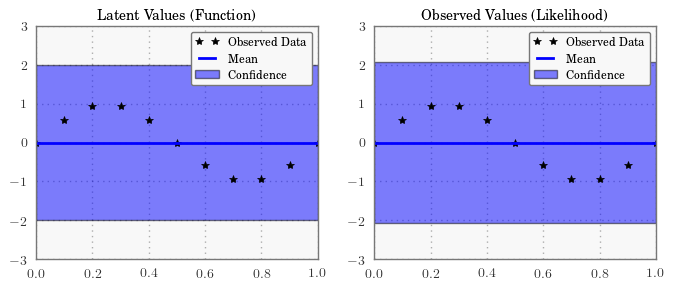

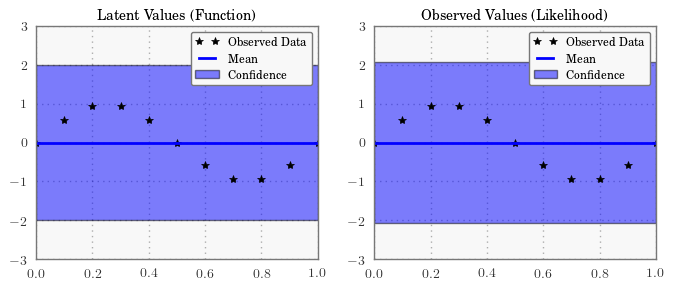

In [6]:
plot_model_and_predictions(prior, likelihood)

In [7]:
from gpytorch.inference import ExactGPInference
infer = ExactGPInference(likelihood)
posterior_latent_distribution = infer.run(prior, train_x, train_y)

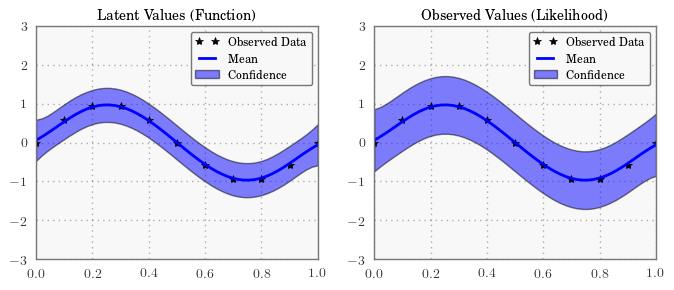

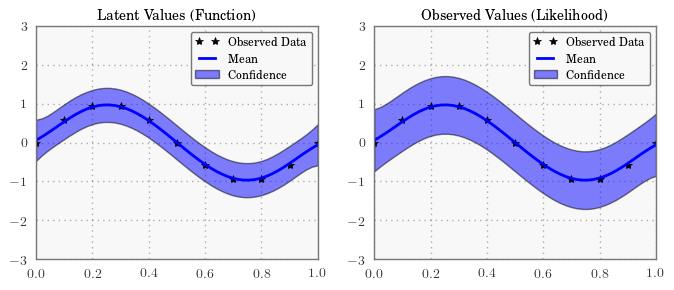

In [8]:
plot_model_and_predictions(posterior_latent_distribution, likelihood)